In [5]:
"""
Update Parameters Here
"""
CONTRACT_ADDRESS = "0x9A534628B4062E123cE7Ee2222ec20B86e16Ca8F"
COLLECTION = "MekaVerse"
METHOD = "raritytools"
TOKEN_COL = "TOKEN_ID"  # Use TOKEN_NAME if you prefer to infer token id from token name
NUMBERS_TO_CHECK = 50  # Number of tokens to search for opportunities

In [6]:
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

from honestnft_utils import config

# Define variables used throughout
PATH = f"{config.RARITY_FOLDER}/{COLLECTION}_{METHOD}.csv"
ETHER_UNITS = 1e18

"""
Plot params
"""
plt.rcParams.update({"figure.facecolor": "white", "savefig.facecolor": "white"})

# Load rarity database and format
RARITY_DB = pd.read_csv(PATH)
RARITY_DB = RARITY_DB[RARITY_DB["TOKEN_ID"].duplicated() == False]
if TOKEN_COL == "TOKEN_NAME":
    RARITY_DB["TOKEN_ID"] = RARITY_DB["TOKEN_NAME"].str.split("#").str[1].astype(int)

           ranks       bid
token_ids                 
6273         2.0  0.756900
6242         3.0  0.756900
7796         5.0  0.756900
8075         6.0  0.800000
4370         9.0  0.756900
7823        11.0  0.756900
3581        13.0  0.755500
7075        14.0  0.755500
7075        14.0  0.756900
7075        14.0  0.800000
1146        15.0  0.755500
1146        15.0  0.800000
3060        16.0  0.821900
7521        17.0  0.756900
4214        18.0  0.756900
4214        18.0  0.755500
6051        19.0  0.800000
6051        19.0  0.756900
5580        20.0  0.756900
7156        22.0  0.755500
7156        22.0  0.756900
7156        22.0  0.800000
945         25.0  0.755500
848         26.0  0.755500
353         27.0  0.811900
8582        29.0  0.699612
6599        30.0  0.756900
6599        30.0  0.755500
2764        31.0  1.700100
5365        32.0  0.756900
6328        34.0  0.756900
6540        35.0  0.755500
6540        35.0  0.756900
7313        37.0  0.756900
3807        39.0  0.755500
7

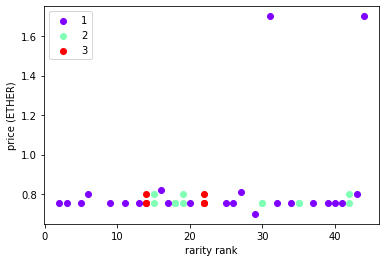

In [7]:
"""
Get open bids from OpenSea and plot.
"""


def getOpenseaOrders(token_id, contract_address):
    url = "https://api.opensea.io/wyvern/v1/orders"

    querystring = {
        "bundled": "false",
        "include_bundled": "false",
        "is_english": "false",
        "include_invalid": "false",
        "limit": "50",
        "offset": "0",
        "order_by": "created_date",
        "order_direction": "desc",
        "asset_contract_address": contract_address,
        "token_ids": [token_id],
    }

    headers = {"Accept": "application/json", "X-API-KEY": config.OPENSEA_API_KEY}

    response = requests.request("GET", url, headers=headers, params=querystring)
    response_json = response.json()
    return response_json


def plot_all_bids(bid_db):
    series = []
    max_listings = bid_db["token_ids"].value_counts().max()

    for i in range(1, max_listings + 1):
        n_bids = bid_db.groupby("token_ids").filter(lambda x: len(x) == i)
        series.append(n_bids)

    colors = iter(cm.rainbow(np.linspace(0, 1, len(series))))
    for i in range(0, len(series)):
        plt.scatter(
            series[i]["ranks"], series[i]["bid"], color=next(colors), label=i + 1
        )
        plt.xlabel("rarity rank")
        plt.ylabel("price (ETHER)")
        plt.legend(loc="best")

    plt.show()


def get_all_bids(rarity_db):
    token_ids = []
    ranks = []
    bids = []
    numbersToCheck = []

    for x in rarity_db["TOKEN_ID"]:
        numbersToCheck.append(x)

        if len(numbersToCheck) == 15:  # send 15 NFTs at a time to API
            orders = getOpenseaOrders(numbersToCheck, CONTRACT_ADDRESS)
            numbersToCheck = []

            for order in orders["orders"]:
                if order["side"] == 0:
                    tokenId = int(order["asset"]["token_id"])
                    token_ids.append(tokenId)
                    ranks.append(
                        float(rarity_db[rarity_db["TOKEN_ID"] == tokenId]["Rank"])
                    )
                    bids.append(float(order["base_price"]) / ETHER_UNITS)

    bid_db = pd.DataFrame(columns=["token_ids", "ranks", "bid"])
    bid_db["token_ids"] = token_ids
    bid_db["ranks"] = ranks
    bid_db["bid"] = bids
    return bid_db


bid_db = get_all_bids(RARITY_DB.head(NUMBERS_TO_CHECK))
bid_db = bid_db.sort_values(by=["ranks"])

print(bid_db.set_index("token_ids").head(50))
plot_all_bids(bid_db)

In [8]:
"""
Get open offers from OpenSea and plot.
"""


def getOpenseaOrders(token_id, contract_address):
    # gets orders, both bids and asks
    # divide token_list into limit sized chunks and get output
    url = "https://api.opensea.io/wyvern/v1/orders"
    querystring = {
        "bundled": "false",
        "include_bundled": "false",
        "is_english": "false",
        "include_invalid": "false",
        "limit": "50",
        "offset": "0",
        "order_by": "created_date",
        "order_direction": "desc",
        "asset_contract_address": contract_address,
        "token_ids": [token_id],
    }

    headers = {"Accept": "application/json", "X-API-KEY": config.OPENSEA_API_KEY}

    response = requests.request("GET", url, headers=headers, params=querystring)
    responseJson = response.json()
    return responseJson


def display_orders(rarity_db):
    print("RANK TOKEN_ID PRICE URL")
    numbersToCheck = []
    for x in rarity_db["TOKEN_ID"]:
        numbersToCheck.append(x)
        if len(numbersToCheck) == 15:
            orders = getOpenseaOrders(numbersToCheck, CONTRACT_ADDRESS)
            numbersToCheck = []
            time.sleep(2)
            for order in orders["orders"]:
                if order["side"] == 1:
                    tokenId = int(order["asset"]["token_id"])
                    price = float(order["current_price"]) / 1e18
                    if price <= 20:
                        current_order = dict()
                        current_order["RANK"] = str(
                            int(rarity_db[rarity_db["TOKEN_ID"] == tokenId]["Rank"])
                        )
                        current_order["TOKEN_ID"] = str(tokenId)
                        current_order["PRICE"] = str(price)
                        current_order[
                            "URL"
                        ] = f"https://opensea.io/assets/{CONTRACT_ADDRESS}/{tokenId}"
                        str_to_print = ""
                        for x in ["RANK", "TOKEN_ID", "PRICE"]:
                            str_to_print += f"{current_order[x]}"
                            str_to_print += " " * (len(x) + 1 - len(current_order[x]))
                        str_to_print += current_order["URL"]
                        print(str_to_print)


display_orders(RARITY_DB.head(NUMBERS_TO_CHECK))

RANK TOKEN_ID PRICE URL
28   1478     5.5   https://opensea.io/assets/0x9A534628B4062E123cE7Ee2222ec20B86e16Ca8F/1478
28   1478     12.0  https://opensea.io/assets/0x9A534628B4062E123cE7Ee2222ec20B86e16Ca8F/1478
42   1070     8.0   https://opensea.io/assets/0x9A534628B4062E123cE7Ee2222ec20B86e16Ca8F/1070
42   1070     9.0   https://opensea.io/assets/0x9A534628B4062E123cE7Ee2222ec20B86e16Ca8F/1070
42   1070     12.0  https://opensea.io/assets/0x9A534628B4062E123cE7Ee2222ec20B86e16Ca8F/1070
42   1070     17.0  https://opensea.io/assets/0x9A534628B4062E123cE7Ee2222ec20B86e16Ca8F/1070
40   7916     12.5  https://opensea.io/assets/0x9A534628B4062E123cE7Ee2222ec20B86e16Ca8F/7916
40   7916     17.5  https://opensea.io/assets/0x9A534628B4062E123cE7Ee2222ec20B86e16Ca8F/7916


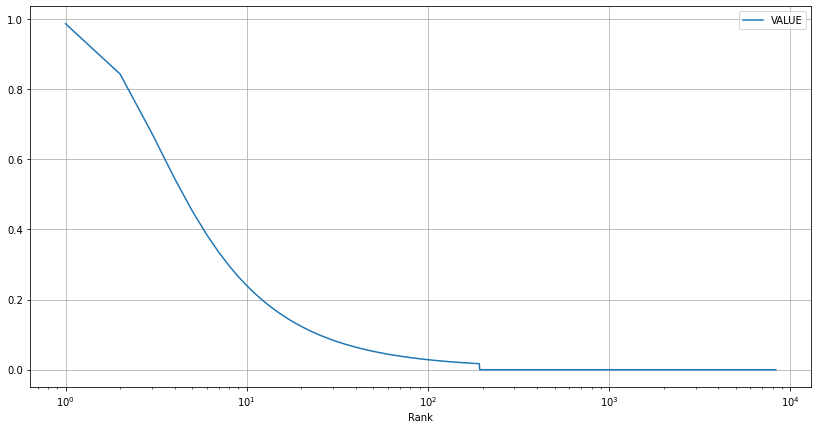

In [9]:
import numpy as np

A = -0.9
K = 1
B = 5
v = 1
Q = 1.1
C = 1

RARITY_DB["VALUE"] = A + (
    (K - A) / np.power((C + Q * np.exp(-B * (1 / RARITY_DB["Rank"]))), 1 / v)
)
RARITY_DB["VALUE"] = np.where(RARITY_DB["Rank"] > 96 * 2, 0, RARITY_DB["VALUE"])
RARITY_DB[["Rank", "VALUE"]].sort_values("Rank").plot(
    x="Rank", y="VALUE", figsize=(14, 7), logx=True, grid=True
)
plt.show()

<AxesSubplot:xlabel='TOKEN_ID'>

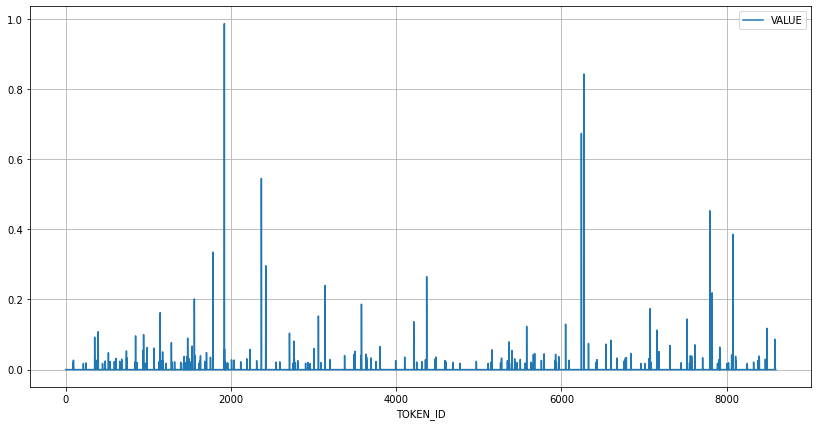

In [10]:
RARITY_DB = RARITY_DB.sort_values("TOKEN_ID")
RARITY_DB.plot(x="TOKEN_ID", y="VALUE", grid=True, figsize=(14, 7))

<AxesSubplot:xlabel='TOKEN_ID'>

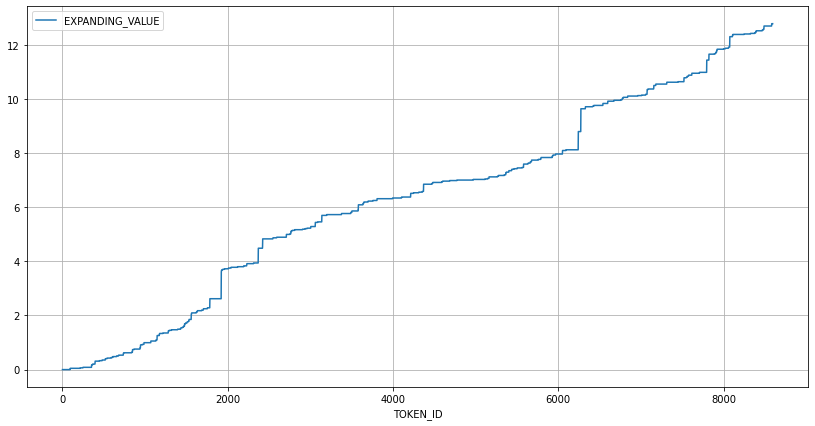

In [11]:
RARITY_DB = RARITY_DB.sort_values("TOKEN_ID")
RARITY_DB["EXPANDING_VALUE"] = RARITY_DB["VALUE"].expanding().sum()
RARITY_DB.plot(x="TOKEN_ID", y="EXPANDING_VALUE", grid=True, figsize=(14, 7))

In [12]:
pd.set_option("display.max_rows", 100)
RARITY_DB.sort_values("Rank").head(96)

,TOKEN_ID,TOKEN_NAME,Color,Meka Type,Helmet,Eyes,Mask,Jaws,Arms,Chest,Colors,Weapon,Material,Status,RARITY_SCORE,Rank,VALUE,EXPANDING_VALUE
0,1922,Meka #1922,22.557379,25474.800000,2769.000000,4392.206897,3639.257143,4899.000000,5789.727273,7492.588235,75.191263,2.002830,3.749603,63687.000000,118247.080623,1,0.986021,3.604848
1,6273,Meka #6273,22.557379,25474.800000,2769.000000,4392.206897,3639.257143,4899.000000,5789.727273,7492.588235,75.191263,2.002830,3.749603,63687.000000,118247.080623,2,0.842650,9.637673
2,6242,Meka #6242,22.557379,25474.800000,2769.000000,4392.206897,3639.257143,4899.000000,5789.727273,7492.588235,75.191263,2.002830,3.749603,63687.000000,118247.080623,3,0.673156,8.795023
3,2370,Meka #2370,6368.700000,18.327194,97.729412,376.474877,128.444370,172.905882,204.343316,264.444291,16.933528,2.002830,299.703529,23.008309,7973.017538,4,0.544696,4.484454
4,7796,Meka #7796,6368.700000,18.327194,97.729412,263.532414,128.444370,172.905882,204.343316,264.444291,77.196364,2.002830,299.703529,23.008309,7920.337911,5,0.452633,11.435928
5,8075,Meka #8075,6368.700000,18.327194,97.729412,263.532414,128.444370,172.905882,204.343316,264.444291,24.618090,2.002830,299.703529,23.008309,7867.759638,6,0.385471,12.301125
6,1784,Meka #1784,22.557379,42.600000,207.675000,366.017241,94.937143,341.790698,190.870130,247.008403,75.191263,1013.586207,3639.257143,23.008309,6264.498916,7,0.334972,2.618826
7,2423,Meka #2423,22.557379,77.509533,159.750000,140.176816,143.654887,145.514851,598.937304,212.054384,75.191263,549.025862,3639.257143,23.008309,5786.637733,8,0.295880,4.829874
8,4370,Meka #4370,22.557379,56.443427,188.795455,387.547667,131.539415,74.604061,81.545455,31.838194,75.191263,549.025862,3639.257143,23.008309,5261.353629,9,0.264838,6.849237
9,3139,Meka #3139,22.557379,18.327194,202.609756,18.050165,52.742857,24.742424,145.959511,51.673022,75.191263,878.441379,3639.257143,23.008309,5152.560404,10,0.239646,5.697806
